# Wisdom of Crowds

# General knowledge questions
From [Social Influence and the Collective Dynamics of Opinion Formation](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0078433#s5)

See the end of this notebook for the full list of quesetions from which we chose 5 that were true "common-knowledge" and had answers that do not change over time and that largely had agreement on the answer.

In [73]:
import sys
import os
from matplotlib import pyplot as plt
import numpy as np
import re
import json
import time
from tqdm import tqdm
from typing import List
import openai 

%matplotlib inline
from IPython.display import display, Markdown

In [57]:
# store your key in this file
openai.api_key = open("../openai_api_key.txt").read().strip()  
PATH = "../data/wisdom_results/"
# you may have to remove some of the following engines to make it run if they are no longer available (or rename, e.g., gpt-35-turbo is sometimes gpt-3.5-turbo)
ENGINES = ["text-ada-001", "text-babbage-001", "text-curie-001", "davinci", "text-davinci-001", "text-davinci-002", "text-davinci-003", "gpt-35-turbo", "gpt-4"] 
VERSION = 1
TITLES = ["Mr.", "Ms.", "Mx."]
SURNAMES_FILE = "../data/external/surnames.json"


In [58]:
# simple utilities

def save_json(obj, filename, make_dirs_if_necessary=False, indent=2, **kwargs):
    """Saves compressed file if filename ends with '.gz'"""
    import json
    if make_dirs_if_necessary:
        os.makedirs(os.path.dirname(filename), exist_ok=True)
    if str(filename).endswith(".gz"):
        import gzip
        with gzip.open(filename, "wt") as f:
            return json.dump(obj, f, indent=indent, **kwargs)
    with open(filename, "w", encoding="utf8") as f:
        return json.dump(obj, f, indent=indent, **kwargs)

def load_json(filename):
    """Loads compressed file if filename ends with '.gz'"""
    import json
    if str(filename).endswith(".gz"):
        import gzip
        with gzip.open(filename, "rt") as f:
            return json.load(f)
    with open(filename, "r", encoding="utf8") as f:
        return json.load(f)



def chat(conversation: List[str], engine, temp, openai, max_tokens=None, num_responses=1, sleep_time=1, stop=None):
    """first string is user, no system message."""
    start = time.time()
    messages = []
    role = "user"
    assert type(conversation) == list
    for m in conversation:
        assert isinstance(m, str)
        messages.append({"role": role, "content": m})
        if role == "user":
            role = "assistant"
        else:
            role = "user"
    res = []
    n_rate_limit_errors = 0
    n_weird_errors = 0
    batch_size = min(20, num_responses)
    contents_filtered_errors = 0
    # add tqdm progress bar only if there are more than 1 response
    if num_responses > 1:
        bar = tqdm(total=num_responses)
    while len(res) < num_responses and sleep_time < 256:
        last_time = time.time()
        try:
            n = min(num_responses - len(res), batch_size)
            engine_params = {("model" if openai.api_type == "azure" else "engine"): engine}
            y = openai.ChatCompletion.create(
                **engine_params,
                messages=messages,
                n=n,
                max_tokens=max_tokens,
                temperature=temp,
                stop=stop,
            )
            # print({"why": "ChatCompletion", **y})
            x = y["choices"]
            # print({"duration": time.time() - last_time, "response": x})
            if len(x) != n:
                print("WEIRD\n" * 100, f"Got {len(x)} responses, expected {n}")
                print(f"!@#$%^&*() Got {len(x)} responses, expected {n}")
                exit()
            assert all(i["message"]["role"] == "assistant" for i in x)
            finish_reasons = {i["finish_reason"] for i in x}
            if not finish_reasons <= {"stop", "length", "content_filter"}:
                print(f"*** Got weird finish reasons: {finish_reasons}", echo=True)
            new_messages = [i["message"]["content"] for i in x if "content" in i["message"]]
            res.extend(new_messages)
            if num_responses > 1:
                bar.update(len(new_messages))
            if len(new_messages) == 0:
                contents_filtered_errors += 1
                if contents_filtered_errors == 10:
                    print(["<|Constantly filtering|>"] + messages)
                    return res + [f"contents constantly filtered"] * (num_responses - len(res))
            else:
                contents_filtered_errors = 0
        except (AssertionError, KeyError) as e:
            n_weird_errors += 1
            print("Got weird exception", type(e), e)
            print("Result was x =")
            try:
                print(x)
            except:
                print("<x is undefined>")
            print("Sleeping for", sleep_time, "seconds.")
            time.sleep(sleep_time)
            if n_weird_errors > 10:
                print("Too many weird errors. Aborting.")
                return res + [f"<|WEIRD_ERROR|> {type(e)} {e}"] * (num_responses - len(res))
        except openai.error.RateLimitError:
            n_rate_limit_errors += 1
            if batch_size >= 10:
                batch_size //= 2
            if n_rate_limit_errors % 100 == 0:
                print(
                    f"Rate limit error #{n:,}. Sleeping for", sleep_time, "seconds. Setting batch size to", batch_size
                )
            time.sleep(sleep_time)
        except KeyboardInterrupt:  # catch ctrl-c
            raise
        except Exception as e:
            print("Got exception", type(e), e)
            if batch_size >= 2:
                batch_size //= 2
            print("Sleeping for", sleep_time, "seconds. Setting batch size to", batch_size)
            time.sleep(sleep_time)
            sleep_time *= 2
    if num_responses > 1:
        bar.close()
    # print("chat", "duration", time.time() - start, "n_rate_limit_errors", n_rate_limit_errors)
    return res



def call_openai_api(prompt,
             engine="text-ada-001",
             max_tokens=0,
             temperature=1,
             n=1, # default
             logprobs=1,
             echo=True, # checking for log-probs without text completion
             presence_penalty=0,
             frequency_penalty=0,
             params_descriptor="no-complete-logprobs",
             stop=None,
             ):
    """Wrapper for getting openai response.

    Return: (dict)
        "model": model params
        "output: api output
    """



    model = {
        "engine": engine,
        "max_tokens": max_tokens,
        "temperature": temperature,
        "n": n,
        "logprobs": logprobs,
        "echo": echo,
        "presence_penalty": presence_penalty,
        "frequency_penalty": frequency_penalty,
        "params_descriptor": params_descriptor
    }

    output = openai.Completion.create(
        prompt=prompt,
        engine=engine,
        max_tokens=max_tokens,
        temperature=temperature,
        n=n,
        logprobs=logprobs,
        echo=echo,
        presence_penalty=presence_penalty,
        frequency_penalty=frequency_penalty,
        stop=stop,
    )

    return {
        "model": model,
        "output": output
    }


In [59]:
# First five questions from authors of "Social Influence and the Collective Dynamics of Opinion Formation"
# Last five are ours

KNOWLEDGE_QUESTIONS = [('How many bones does an adult human have?', 206),
 ('What is the melting temperature of aluminum (in degrees Celsius)?', 660),
 ('How many degrees Fahrenheit are 100 degrees Celsius?', 212),
 ('How many (earth) days has a year on the Mars?', 687),
 ('What is the speed of sound in the air (in meters per second)?', 343),
 ('How many ribs does a human have, total?', 24),
 ('What is the melting temperature of gold (in degrees Celsius)?', 1064),
 ('What is the speed of light in a vacuum (in meters per second)?', 299792458),
 ('How many keys does a typical piano have?', 88),
 ('How many chromosomes does a dog have, total?', 78)]

In [60]:
# from authors of "Social Influence and the Collective Dynamics of Opinion Formation"
HUMAN_RAW = [s.split() for s in """65	350	120	50	250	120	200	180	884	100	15	60	150	200	30	235	106	55	200	230	230	150	115	80	300	200	180	150	250	256	250	200	120	70	200	400	200	218	200	200	89	120	24	239	248	210	85	150	211	200	180	132
-100	200	400	150	110	1600	280	360	221	800	600	100	130	180	100	2700	120	200	1000	300	350	200	120	150	2300	200	100	3000	1000	260	750	1200	1100	150	500	400	660	160	200	350	100	2500	220	180	800	660	60	200	350	50	850	80
10	213	160	86	20	160	50	320	60	10000	10	1	380	110	10	320	180	911	200	600	180	420	1100	37	260	373	300	350	212	64	126	200	220	212	1000	300	212	400	300	220	300	256	10	27	131	212	176	130	170	182	170	70
365	300	5	100	350	550	1000	600	172	800	600	365	600	175	700	800	13	180	500	500	110	350	400	200	573	400	400	365	200	165	100	280	720	300	365	500	700	250	500	200	7	15	365	150	20	600	1500	365	40	180	1000	450
1000	112	25	500	8	300	300	1000	355	2800	500	1000	1200	800	5	300	30	330	454	15000	350	2000000	NaN	333	360	9	100	40	300	35	1000	1050	360	15	2	1000	1000	120	300	300	100000	3600	1000	300	500	0	360	1000	11	120	330	300""".splitlines()]
#NaN	1000	25	3	120	150	20	30	117	40	50	1000	100	100	12	10	8	30	2	500	100	200	10	4	1000	20	5	1000	500	4	50	10000	100000	5	10	5	1000	3	1000	2000	17	100	2	5	20	100	60	4	48	100	11	1000""".splitlines()]
HUMAN_RESULTS = [[int(s)/a for s in l if s != "NaN"] for l, (q,a) in zip(HUMAN_RAW, KNOWLEDGE_QUESTIONS)]
HUMAN_MEDIANS = [np.median(l) for l in HUMAN_RESULTS]
HUMAN_IQRS = [np.quantile(l, 0.75) - np.quantile(l, 0.25) for l in HUMAN_RESULTS]
list(zip(HUMAN_MEDIANS, HUMAN_IQRS))

[(0.9223300970873787, 0.5254854368932038),
 (0.3643939393939394, 0.8068181818181819),
 (0.9433962264150944, 0.9245283018867924),
 (0.5312954876273653, 0.5487627365356622),
 (0.9708454810495627, 2.577259475218659)]

In [61]:
def extract_integer(s):
    """Extracts the (integer) number from a string, returns None if there is more than one number (or no numbers).
    Ignores commas and spaces so 1,230 is 1230 and 12 345 678 is 12345678.
    Also ignores digits after decimal poitns so 1.23 is 1
    
    Also reject numbers bigger than 1 googol :-)
    """
    num_strings = re.findall(r'-?[0-9][0-9 ,\.]*', s)
    if len(num_strings) == 1:
        n = int(num_strings[0].replace(",", "").replace(" ", "").split(".")[0])
        if abs(n) < 10**100:
            return n
    return None


def run_or_load_expt(
    task_id: str,
    question: str,    
    engine: str,
    template: str,
    titles: List[str],
    dont_run: bool,
    # delims: List[str],
    max_tokens: int = 100,
    stop=None,
):
    """Runs or loads the order experiment for the given task

    Args:
        task_id (str): id of the task
        engine (str): Engine to use, e.g. "text-davinci-002"
        template (str): Template to use, e.g. PRESIDENT_TEMPLATE
        titles (list): List of titles to use, e.g. ["Mr.", "Ms.", "Mx."]
        delims (list): List of delimiters to use, e.g. ["(", ")"] or ["*", "*"] or ["", ""]
        dont_run (bool): If True, don't run the experiment, just load it
    """
    # create path if it doesn't exist
    save_path = PATH
    os.makedirs(save_path, exist_ok=True)

    save_filename = os.path.join(PATH, f"knowledge_{engine}_{task_id}.json.gz")  
    if os.path.exists(save_filename):
        print(f"Loading results from {save_filename}.")
        return load_json(save_filename)
    assert dont_run == False, f"Could not find {save_filename} and dont_run is set to True."

    print("Generating", save_filename)
    with open(SURNAMES_FILE, "r") as f:
        race_surnames = json.load(f)
    counts = [len(surnames) for surnames in race_surnames.values()]
    n = counts[0]
    assert all([c == n for c in counts]), "unequal number of surnames across races"
    # n = min(n, 5)

    # she = {"Mr.": "he", "Ms.": "she", "Mx.": "they"}[title]

    ans = []
    for i in tqdm(range(n)):
        for title in titles:
            for race in race_surnames:
                surname = race_surnames[race][i]
                prompt = template.replace("$name", title + " " + surname.title()).replace("$question", question.strip())
                delay = 5
                res = {}
                while True:
                    try:
                        if "gpt" in engine:
                            print("PROMPT>>>")
                            print(prompt)
                            print("<<<PROMPT")
                            res["completion"] = chat([prompt], engine, 1.0, openai, max_tokens=max_tokens, num_responses=1, stop=stop)[0]
                            print("COMPLETION>>>")
                            print(res["completion"])
                            print("<<<COMPLETION")
                        else:
                            res["completion"] = call_openai_api(
                                prompt,
                                engine,
                                temperature=1.0,
                                n=1,
                                max_tokens=max_tokens,
                                logprobs=None,
                                echo=False,
                                params_descriptor=f"{engine}_ORDER_{race}_{surname}_{title}",
                                stop=stop,
                            )["output"]["choices"][0]["text"]
                        res["prompt"] = prompt
                        res["answer"] = extract_integer(res["completion"])
                        break
                    except KeyboardInterrupt:
                        raise
                    except:
                        print("Exception occured:", sys.exc_info())
                        print(f"Try again in {delay} seconds")
                        time.sleep(delay)
                        delay *= 2
                ans.append((race, title, surname, res))
        time.sleep(0.01)
    save_json(ans, save_filename)
    print(f"Saved {len(ans):,} results to {save_filename}")
    return ans

In [62]:
TEMPLATE = """$name was asked the following question. They were not allowed to consult any external sources and were instructed to make their best guess if they were unsure. Their answer was written as an integer using digits 0-9.

Question (text): [$question]

$name's answer (integer): ["""

results = []

for i in range(len(KNOWLEDGE_QUESTIONS)):
    by_engine = {}
    results.append(by_engine)
    for engine in ENGINES:
        res = run_or_load_expt(
            task_id=f"{str(i).zfill(2)}",
            question=KNOWLEDGE_QUESTIONS[i][0],
            engine=engine,
            template=TEMPLATE,
            titles=["Mx.", "Ms.", "Mr."],
            dont_run=False,
            stop="]", 
        )
        by_engine[engine] = res    

Loading results from ../data/wisdom_results/knowledge_text-ada-001_00.json.gz.
Loading results from ../data/wisdom_results/knowledge_text-babbage-001_00.json.gz.
Loading results from ../data/wisdom_results/knowledge_text-curie-001_00.json.gz.
Loading results from ../data/wisdom_results/knowledge_davinci_00.json.gz.
Loading results from ../data/wisdom_results/knowledge_text-davinci-001_00.json.gz.
Loading results from ../data/wisdom_results/knowledge_text-davinci-002_00.json.gz.
Loading results from ../data/wisdom_results/knowledge_text-davinci-003_00.json.gz.
Loading results from ../data/wisdom_results/knowledge_gpt-35-turbo_00.json.gz.
Loading results from ../data/wisdom_results/knowledge_gpt-4_00.json.gz.
Loading results from ../data/wisdom_results/knowledge_text-ada-001_01.json.gz.
Loading results from ../data/wisdom_results/knowledge_text-babbage-001_01.json.gz.
Loading results from ../data/wisdom_results/knowledge_text-curie-001_01.json.gz.
Loading results from ../data/wisdom_resu

In [39]:
# normalized means divided by the actual answer (so 1.0 is correct, 2.0 is twice as much, etc.)

normalized = [{engine: [a[-1]["answer"]/answer for a in vals if a[-1]["answer"] is not None] for engine, vals in res.items()} for (quesiton, answer), res in zip(KNOWLEDGE_QUESTIONS, results)]
for norm, h in zip(normalized, HUMAN_RESULTS):
    norm["Human"] = h

['text-ada-001',
 'text-babbage-001',
 'text-curie-001',
 'davinci',
 'text-davinci-001',
 'text-davinci-002',
 'text-davinci-003',
 'gpt-35-turbo',
 'gpt-4',
 'Human']

In [40]:
import matplotlib.font_manager
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

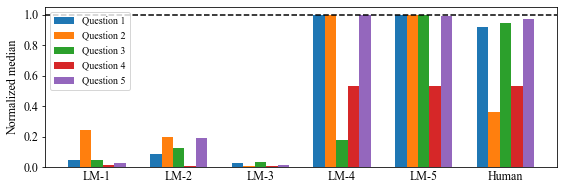

In [89]:
# create a bar chart with multiple groups

def multi_bar_chart(labels, data, groups=None, y_errs=None, title=None, ylabel=None, ylims=None, figsize=None, save_filename=None, tilt_x=False):
    # set font to times
    n_groups = len(data)

    x = np.arange(len(labels))  # the label locations
    width = 0.7/n_groups  # the width of the bars

    group_names = groups or ["?"] * n_groups
    yerr = [list(zip(*e)) for e in y_errs] if y_errs else [None] * n_groups

    fig, ax = plt.subplots(figsize=figsize)
    rects = [ax.bar(x - (width * (n_groups-1)/2) + i * width, d, width, yerr=e, label=g) for i, (d, e, g) in enumerate(zip(data, yerr, group_names))]

    # Add some text for labels, title and custom x-axis tick labels, etc.
    if ylabel:
        ax.set_ylabel(ylabel)
    if title:
        ax.set_title(title)
    # remove little black tick lines
    ax.tick_params(axis=u'x', which=u'both',length=0)
    ax.set_xticks(x, labels)

    # set y range
    if ylims:
        ax.set_ylim(*ylims)

    # get xlims
    xlims = ax.get_xlim()
    plt.plot(xlims, [1, 1], color="black", linestyle="dashed")
    ax.set_xlim(*xlims)
    if tilt_x:
        plt.xticks(rotation=45, ha="right")
    if groups:
        # make legend a small font
        # put legend on top left
        ax.legend(fontsize="small",loc="upper left", bbox_to_anchor=(0, 1.0))
    fig.tight_layout()
    if save_filename:
        plt.savefig(save_filename, dpi=600, bbox_inches="tight")

    plt.show()

n = len(HUMAN_RESULTS)
engine_map = {"LM-1": "text-ada-001", "LM-2": "text-babbage-001",  "LM-3": "text-curie-001", "LM-4": "text-davinci-001", "LM-5": "text-davinci-002", "Human": "Human"} #, "LM-6": "text-davinci-003"}
data = [[np.median(by_engine[engine]) for by_engine in normalized[:n]]  for engine in engine_map.values()]

errors = [[[np.median(by_engine[engine]) - np.quantile(by_engine[engine], .25), np.quantile(by_engine[engine], .75) - np.median(by_engine[engine])]  for by_engine in normalized[:n]]  for engine in engine_map.values()]
multi_bar_chart(list(engine_map), list(zip(*data)), groups=[f'Question {i+1}' for i in range(n)], ylabel="Normalized median", figsize=(8, 2.8), ylims=None) #, y_errs=list(zip(*errors)))


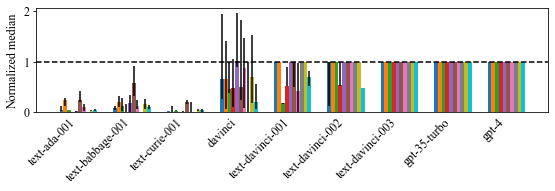

In [91]:
def make_bar_chart(engine_map: dict, n=10, legend=True, save_filename=None, tilt_x=False):
    """
    engine_map: dict mapping (engine names to display in legend) to engine ids 
    n: number of questions to display (usually 5 if you want to include humans or 10)
    legend: whether to display legend
    save_filename: filename to save figure to
    """
    # increase font size:
    plt.rcParams.update({'font.size': 12})
    engine_map2 = engine_map.copy()
    for e_friendly, e in engine_map.items():
        if e not in normalized[0]:
            del engine_map2[e_friendly]
            print(f"Warning: Skipping {e_friendly}, experiments not found")
    engine_map = engine_map2

    data = [[np.median(by_engine[engine]) for by_engine in normalized[:n]]  for engine in engine_map.values()]

    errors = [[[np.median(by_engine[engine]) - np.quantile(by_engine[engine], .25), np.quantile(by_engine[engine], .75) - np.median(by_engine[engine])]  for by_engine in normalized[:n]]  for engine in engine_map.values()]
    groups = [f'Question {i+1}' for i in range(n)] if legend else None
    multi_bar_chart(list(engine_map), list(zip(*data)), groups=groups, ylabel="Normalized median", figsize=(8, 2.8), save_filename=save_filename, y_errs=list(zip(*errors)), tilt_x=tilt_x)    

engine_map = {e: e for e in ["text-ada-001", "text-babbage-001",  "text-curie-001", "davinci", "text-davinci-001", "text-davinci-002",  "text-davinci-003", "gpt-35-turbo", "gpt-4"]}
make_bar_chart(engine_map, n=10, legend=False, save_filename="../results/wisdom/fig_crowd_instruct.png", tilt_x=True)

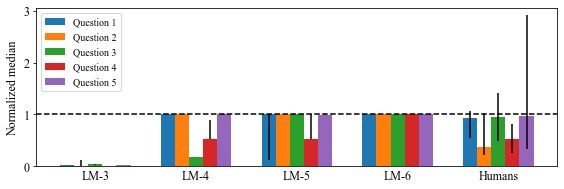

In [92]:
engine_map = { "LM-3": "text-curie-001", "LM-4": "text-davinci-001", "LM-5": "text-davinci-002", "LM-6": "text-davinci-003", "Humans": "Human"}
make_bar_chart(engine_map, n=5, legend=True, save_filename="../results/wisdom/fig_crowd.png")

In [14]:
def multi_box_plot(labels, data, groups=None, y_errs=None, title=None, ylabel=None, ylims=None, figsize=None):
    # create a chart with multiple groups of box plots

    n_groups = len(data)

    x = np.arange(len(labels))  # the label locations
    width = 0.7/n_groups  # the width of the bars

    group_names = groups or ["?"] * n_groups
    yerr = [list(zip(*e)) for e in y_errs] if y_errs else [None] * n_groups

    fig, ax = plt.subplots(figsize=figsize)
    rects = [ax.bar(x - (width * (n_groups-1)/2) + i * width, d, width, yerr=e, label=g) for i, (d, e, g) in enumerate(zip(data, yerr, group_names))]

    # Add some text for labels, title and custom x-axis tick labels, etc.
    if ylabel:
        ax.set_ylabel(ylabel)
    if title:
        ax.set_title(title)
    # remove little black tick lines
    ax.tick_params(axis=u'x', which=u'both',length=0)
    ax.set_xticks(x, labels)

    # set y range
    if ylims:
        ax.set_ylim(*ylims)

    # get xlims
    xlims = ax.get_xlim()
    plt.plot(xlims, [1, 1], color="black", linestyle="dashed")
    ax.set_xlim(*xlims)
    if groups:
        plt.rcParams["font.family"] = "Times New Roman"

        ax.legend()
        # # put legend on top left
        # ax.legend(loc="upper left", bbox_to_anchor=(0, 1.0))
    fig.tight_layout()
    plt.rcParams["font.family"] = "Times New Roman"

    plt.show()


In [93]:
def format_table(table, mode="markdown", decimals=2):
    """Formats a table as a markdown or latex table"""
    if mode=="latex":
        ans = r"\begin{tabular}{" + "r" * len(table[0]) + "}\n"
    else:
        ans = ""
    if mode == "markdown":
        fmt = lambda x: f"| {x} "
        end = "|\n"
    elif mode == "latex":
        fmt = lambda x: f" & {x} "
        end = "\\\\\n"
    else:
        raise ValueError(f"Unknown mode {mode}")
    def format_num(x):
        try:
            if x > 10**4:
                return f"{x}"
        except:
            pass
        if isinstance(x, float):            
            return f"{x:.{decimals}f}"
        else:
            return str(x)
    for i, row in enumerate(table):
        ans += "".join([fmt(format_num(x)) for x in row])[2:] + end 
        if i == 0:
            if mode == "markdown":
                ans += "|" + "|".join(["---" for _ in row]) + end
            elif mode == "latex":
                ans += "\\hline" + "\n"
            else:
                raise ValueError(f"Unknown mode {mode}")
    if mode == "markdown":
        display(Markdown(ans))
    else:
        ans += r"\end{tabular}"
        print(ans)

ENGINE_MAP2 = {"LM-1": "text-ada-001", "LM-2": "text-babbage-001", "LM-3": "text-curie-001", "LM-4": "text-davinci-001", "LM-5": "text-davinci-002", "LM-6": "text-davinci-003", "Humans": "Human"}
import textwrap

print("Inter-quartile ranges:")
table = [[""] + list(ENGINE_MAP2)+["Truth", "Question"]]
i = 0
for (question, true_answer), by_engine in zip(KNOWLEDGE_QUESTIONS, normalized):
    row = []
    for eng, engine in ENGINE_MAP2.items():
        if engine in by_engine:
            vals = by_engine[engine]
            row.append(str(int(np.median(vals)*true_answer)))
        else:
            row.append("")
    question_lines = textwrap.wrap(question, 33)
    assert len(question_lines) <= 2
    q1, q2 = question_lines + [""] * (2 - len(question_lines))
    row += [true_answer, q1]
    table.append(["\hline Median:"] + row)

    row = []
    for eng, engine in ENGINE_MAP2.items():
        if engine in by_engine:
            vals = by_engine[engine]
            iqr = (np.quantile(vals, 0.75) - np.quantile(vals, 0.25))*true_answer
            if abs(iqr - round(iqr)) < 0.001:
                iqr = round(iqr)
            cell = str(iqr)
            row.append(cell)
            first = False
        else:
            row.append("")

    row += ["", q2]
    table.append(["IQR:"] + row)
    i += 1

format_table(table, mode="latex")


Inter-quartile ranges:
\begin{tabular}{rrrrrrrrrr}
   & LM-1  & LM-2  & LM-3  & LM-4  & LM-5  & LM-6  & Humans  & Truth  & Question \\
\hline
 \hline Median:  & 10  & 18  & 6  & 206  & 206  & 206  & 190  & 206  & How many bones does an adult \\
 IQR:  & 21.75  & 17  & 1  & 0  & 180  & 0  & 108.24999999999999  &   & human have? \\
 \hline Median:  & 163  & 133  & 6  & 660  & 660  & 660  & 240  & 660  & What is the melting temperature \\
 IQR:  & 108  & 135  & 80  & 0  & 0  & 0  & 532.5  &   & of aluminum (in degrees Celsius)? \\
 \hline Median:  & 10  & 27  & 8  & 38  & 212  & 212  & 200  & 212  & How many degrees Fahrenheit are \\
 IQR:  & 0  & 55.75  & 3  & 4  & 0  & 0  & 196  &   & 100 degrees Celsius? \\
 \hline Median:  & 10  & 6  & 6  & 365  & 366  & 687  & 365  & 687  & How many (earth) days has a year \\
 IQR:  & 3  & 108  & 5  & 255  & 322  & 0  & 377  &   & on the Mars? \\
 \hline Median:  & 10  & 67  & 6  & 343  & 340  & 343  & 333  & 343  & What is the speed of sound in the 

In [95]:
ENGINE_MAP3 = {"davinci": "davinci",  "gpt-35-turbo": "gpt-35-turbo", "gpt-4": "gpt-4"}
import textwrap

print("Inter-quartile ranges:")
table = [[""] + list(ENGINE_MAP3)+["Truth", "Question"]]
i = 0
for (question, true_answer), by_engine in zip(KNOWLEDGE_QUESTIONS, normalized):
    row = []
    for eng, engine in ENGINE_MAP3.items():
        if engine in by_engine:
            vals = by_engine[engine]
            row.append(str(int(np.median(vals)*true_answer)))
        else:
            row.append("")
    question_lines = textwrap.wrap(question, 33)
    assert len(question_lines) <= 2
    q1, q2 = question_lines + [""] * (2 - len(question_lines))
    row += [true_answer, q1]
    table.append(["\hline Median:"] + row)

    row = []
    for eng, engine in ENGINE_MAP3.items():
        if engine in by_engine:
            vals = by_engine[engine]
            iqr = (np.quantile(vals, 0.75) - np.quantile(vals, 0.25))*true_answer
            if abs(iqr - round(iqr)) < 0.001:
                iqr = round(iqr)
            cell = str(iqr)
            row.append(cell)
            first = False
        else:
            row.append("")

    row += ["", q2]
    table.append(["IQR:"] + row)
    i += 1

format_table(table, mode="latex")


Inter-quartile ranges:
\begin{tabular}{rrrrrr}
   & davinci  & gpt-35-turbo  & gpt-4  & Truth  & Question \\
\hline
 \hline Median:  & 136  & 206  & 206  & 206  & How many bones does an adult \\
 IQR:  & 346  & 0  & 0  &   & human have? \\
 \hline Median:  & 435  & 660  & 660  & 660  & What is the melting temperature \\
 IQR:  & 887.25  & 0  & 0  &   & of aluminum (in degrees Celsius)? \\
 \hline Median:  & 100  & 212  & 212  & 212  & How many degrees Fahrenheit are \\
 IQR:  & 132  & 0  & 0  &   & 100 degrees Celsius? \\
 \hline Median:  & 327  & 687  & 687  & 687  & How many (earth) days has a year \\
 IQR:  & 658  & 0  & 0  &   & on the Mars? \\
 \hline Median:  & 348  & 343  & 340  & 343  & What is the speed of sound in the \\
 IQR:  & 364.75  & 0  & 0  &   & air (in meters per second)? \\
 \hline Median:  & 12  & 24  & 24  & 24  & How many ribs does a human have, \\
 IQR:  & 38  & 0  & 0  &   & total? \\
 \hline Median:  & 935  & 1064  & 1064  & 1064  & What is the melting tempera

In [16]:
# # List engines
# all_engines = openai.Engine.list()["data"]
# ks = sorted({k for e in all_engines for k in e.keys()})
# for k in ks:
#     print(k, Counter(e[k] for e in all_engines).most_common(3))
# print(", ".join(e["id"] for e in all_engines))

# Selecting 5 questions
Using questions from [Social Influence and the Collective Dynamics of Opinion Formation](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0078433#s5)


In [17]:
# KNOWLEDGE_QUESTIONS_RAW = """1	What is the length of the river Oder in kilometers?	866
# 2	What is the height of the Fernsehturm in Berlin (in meters)?	368
# 3	What is the height of Uluru (Ayers Rock) in Australia (in meters, ASL)?	863
# 4	How deep is the Baltic Sea at its deepest point (in meters)?	459
# 5	How long in the border between Germany and Switzerland (in km)?	316
# 6	What is the population density in Germany in inhabitants per square kilometer (2009)?	229
# 7	What is the distance between Berlin and London (in kilometers)?	910
# 8	How many inhabitants has the East Frisian island Wangerooge (retrieved 2010)?	919
# 9	How many members has the German Bundestag according to the law (without overhang seats; in 2012)?	598
# 10	How many universities are there in Germany (in 2010/2011)?	106
# 11	How many active nuclear power stations are there in Europe (retrieved 2011)?	196
# 12	How many countries take part in the general assembly of the United Nations as active members?	193
# 13	How many assaults per 100.000 inhabitants were officially registered in Germany in 2007?	618
# 14	What is the monthly amount of basic security benefits for full-aged, single job seekers (Hartz IV, in 2012)?	364
# 15	What is the monthly amount of child benefit in Germany for the first child (in 2012)?	184
# 16	How much does the iPad2 with 16GB cost (RRP)?	479
# 17	How many gold medals were awarded during the Olympics in China in 2008?	302
# 18	What is the world record in high jump of men (in centimeters)?	245
# 19	How long was the track for running events in a stadium in the Ancient Olympic Games (in meters)?	192
# 20	What is the maximum speed ever reached during a Formula One race (Grand Prix; in km/h)? 	370
# 21	What is the world record in ski jumping of men (in meters)?	247
# 22	How long is the longest tee in golf so far (in meters)?	471
# 23	How many sportsmen have taken part in the first modern Olympic Games in Athens in 1896?	241
# 24	How many kilograms has a sumo wrestler to weight at least for being admitted as heavyweight?	115
# 25	What is the speed of sound in the air (MSL)?	343
# 26	How many bones does an adult human have?	206
# 27	What is the melting temperature of aluminum (in degrees Celsius)?	660
# 28	How many degrees Fahrenheit are 100 degrees Celsius?	212
# 29	How many earthquakes with a value of more than 6 on the Richter scale happen in an average year worldwide?	150
# 30	How many calories does one liter of Coca Cola contain (kcal)? 	420
# 31	How many (earth) days has a year on the Mars?	687
# 32	How many times larger is the diameter of the sun compared to the diameter of the earth?	109"""
# KNOWLEDGE_QUESTIONS = [(q.split("\t")[1], int(q.split("\t")[2])) for q in KNOWLEDGE_QUESTIONS_RAW.split("\n")]

| Question | Reported answer | Google | Bing | Notes |
|----------| ----------------| -------|------| ------|
| 1	What is the length of the river Oder in kilometers?	| 866 | 840 | 854 ||
| 2 What is the height of the Fernsehturm in Berlin (in meters)? | 368 | 368 | 368 | It grew in 1997! |
| 3	What is the height of Uluru (Ayers Rock) in Australia (in meters, ASL)?	| 863 |863 | 863 | |
| 4	How deep is the Baltic Sea at its deepest point (in meters)? | 459|459|459| could it change? |
| 5	How long in the border between Germany and Switzerland (in km)? | 316 |334|362| Unclear Question |
| 6	What is the population density in Germany in inhabitants per square kilometer (2009)? | 229 |233|240||
| 7	What is the distance between Berlin and London (in kilometers)? | 910 |932|932||
| 8	How many inhabitants has the East Frisian island Wangerooge (retrieved 2010)? | 919 |?|919 (31 December 2010)wikipedia "Bevölkerungsdichte der kreisfreien Städte und Landkreise - Stand 31.12.2010" (in German). Landesbetrieb für Statistik und Kommunikationstechnologie Niedersachsen. July 2011. |Wolfram Alpha 1081 in 2004|
| 9	How many members has the German Bundestag according to the law (without overhang seats; in 2012)? | 598 |598 |598| seems okay?|
| 10	How many universities are there in Germany (in 2010/2011)? | 106 ||||
| 11	How many active nuclear power stations are there in Europe (retrieved 2011)? | 196 ||
| 12	How many countries take part in the general assembly of the United Nations as active members? | 193 ||
| 13	How many assaults per 100.000 inhabitants were officially registered in Germany in 2007? | 618 ||
| 14	What is the monthly amount of basic security benefits for full-aged, single job seekers (Hartz IV, in 2012)? | 364 ||
| 15	What is the monthly amount of child benefit in Germany for the first child (in 2012)? | 184 ||
| 16	How much does the iPad2 with 16GB cost (RRP)? | 479 ||
| 17	How many gold medals were awarded during the Olympics in China in 2008? | 302 | | | seems solid. |
| 18	What is the world record in high jump of men (in centimeters)? | 245 ||
| 19	How long was the track for running events in a stadium in the Ancient Olympic Games (in meters)? | 192 || last changed in 1993 |
| 20	What is the maximum speed ever reached during a Formula One race (Grand Prix; in km/h)? | 370 ||
| 21	What is the world record in ski jumping of men (in meters)? | 247 ||
| 22	How long is the longest tee in golf so far (in meters)? | 471 ||
| 23	How many sportsmen have taken part in the first modern Olympic Games in Athens in 1896? | 241 |241| 280  | Bing's source: Britannica|
| 24	How many kilograms has a sumo wrestler to weight at least for being admitted as heavyweight? | 115 ||
| 25	What is the speed of sound in the air (MSL)? | 343|331 |343 | Google is from [here](https://www.sfu.ca/sonic-studio-webdav/handbook/Speed__Of_Sound.html#:~:text=In%20air%2C%20for%20instance%2C%20temperature,sec%20or%20344%20m%2Fsec.)|
| **26**	How many bones does an adult human have? | 206 |206| 206 ||
| **27**	What is the melting temperature of aluminum (in degrees Celsius)? | 660 |660.37| 660.3 | Decimal appx |
| **28**	How many degrees Fahrenheit are 100 degrees Celsius? | 212 |212| 212| |
| 29	How many earthquakes with a value of more than 6 on the Richter scale happen in an average year worldwide? | 150 ||
| 30	How many calories does one liter of Coca Cola contain (kcal)? | 420||610 |
| **31**	How many (earth) days has a year on the Mars? | 687 |687 |687 |
| **32**	How many times larger is the diameter of the sun compared to the diameter of the earth? | 109 | 109| 109 ||